In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Using GPU   
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not, use CPU
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### Importing and Installing Required Libraries

In [ ]:
pip install bert

In [ ]:
pip install bert-tokenizer

In [ ]:
 pip install transformers

In [ ]:
pip install gensim

In [ ]:
pip install pyLDAvis --user

In [ ]:
pip install wordcloud

In [ ]:
import numpy as np
import random

from tqdm.notebook import tqdm
import pandas as pd

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
re.compile('<title>(.*)</title>')

import seaborn as sns
import gensim
from gensim import corpora, models, similarities
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


### Reading the data

In [ ]:
df = pd.read_csv('./TA_Training_Set.csv')
df_new = pd.read_csv('./TA_Test_Set.csv')

In [ ]:
df.head()

,Comment,Topic
0,Very hot and sexy nail color;),21
1,"I know, right? Like, an FMEA. I definitely kno...",28
2,"Hello, we only allow people with an account ag...",5
3,Megumin reads das kapital??? New best girl.,2
4,Freedom of speech ? but you use a random anon ...,13


In [ ]:
df
df.shape

(900000, 2)

In [ ]:
comments = df[['Comment']]
comments.head()

,Comment
0,Very hot and sexy nail color;)
1,"I know, right? Like, an FMEA. I definitely kno..."
2,"Hello, we only allow people with an account ag..."
3,Megumin reads das kapital??? New best girl.
4,Freedom of speech ? but you use a random anon ...


### Tokenizing and Removing Stopwords

In [ ]:
comments['tokenized_comments'] = comments.apply(lambda row: nltk.word_tokenize(row['Comment']), axis=1)
comments.head()

,Comment,tokenized_comments
0,Very hot and sexy nail color;),"[Very, hot, and, sexy, nail, color, ;, )]"
1,"I know, right? Like, an FMEA. I definitely kno...","[I, know, ,, right, ?, Like, ,, an, FMEA, ., I..."
2,"Hello, we only allow people with an account ag...","[Hello, ,, we, only, allow, people, with, an, ..."
3,Megumin reads das kapital??? New best girl.,"[Megumin, reads, das, kapital, ?, ?, ?, New, b..."
4,Freedom of speech ? but you use a random anon ...,"[Freedom, of, speech, ?, but, you, use, a, ran..."


In [ ]:
stop = stopwords.words('english')
comments['stopwords_removed'] = comments['tokenized_comments'].apply(lambda y: [item for item in y if item.lower() not in stop])
comments.head()

,Comment,tokenized_comments,stopwords_removed
0,Very hot and sexy nail color;),"[Very, hot, and, sexy, nail, color, ;, )]","[hot, sexy, nail, color, ;, )]"
1,"I know, right? Like, an FMEA. I definitely kno...","[I, know, ,, right, ?, Like, ,, an, FMEA, ., I...","[know, ,, right, ?, Like, ,, FMEA, ., definite..."
2,"Hello, we only allow people with an account ag...","[Hello, ,, we, only, allow, people, with, an, ...","[Hello, ,, allow, people, account, age, 7, day..."
3,Megumin reads das kapital??? New best girl.,"[Megumin, reads, das, kapital, ?, ?, ?, New, b...","[Megumin, reads, das, kapital, ?, ?, ?, New, b..."
4,Freedom of speech ? but you use a random anon ...,"[Freedom, of, speech, ?, but, you, use, a, ran...","[Freedom, speech, ?, use, random, anon, accoun..."


In [ ]:
comments['punctuations_removed'] = comments['stopwords_removed'].apply(lambda y: [re.sub(r'[^A-Za-z0-9]+', '', item) for item in y])
comments['punctuations_removed'] = comments['punctuations_removed'].apply(lambda y: [item for item in y if item])

In [ ]:
def join_all():
    x = ' '.join(comments["punctuations_removed"])

In [ ]:
comments['clean_comments'] = comments['punctuations_removed'].apply(lambda y: ' '.join(y))

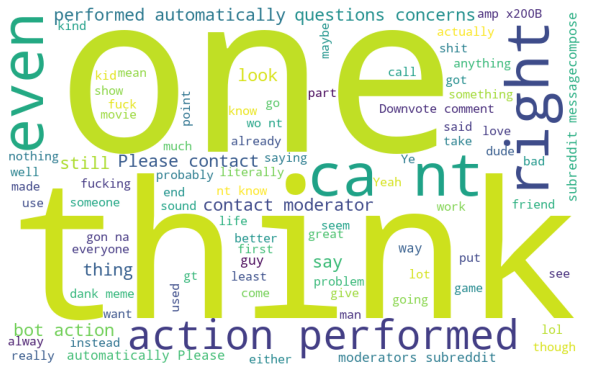

In [ ]:
# Plotting wordcloud
temp=' '.join(comments['clean_comments'].tolist())
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(temp)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

In [ ]:
df_plot = df[['Topic']]

In [ ]:
df_plot['Topic'] = df_plot['Topic'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_plot['Count'] = 1

In [ ]:
df_plot = df_plot.groupby(by=['Topic']).sum()

In [ ]:
df_new = df_plot.reset_index()

In [ ]:
df_new.sort_values(by='Count',ascending=True,inplace=True)

In [ ]:
df_new.head()

,Topic,Count
34,40,22436
35,5,22439
4,13,22450
18,26,22452
7,16,22453


Text(0, 0.5, 'Count of comments')

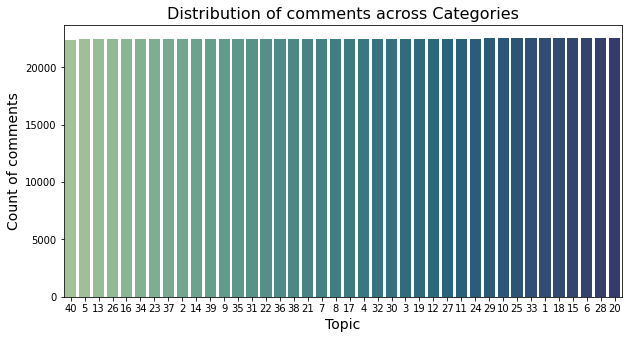

In [ ]:
# Plotting Distribution of comments
sns.dark_palette("#69d", reverse=True, as_cmap=True)
plt.figure(figsize=(10,5))
sns.barplot(x="Topic",y="Count",data =  df_new,palette='crest')
plt.title('Distribution of comments across Categories',fontsize=16)
plt.xlabel('Topic',fontsize=14)
plt.ylabel('Count of comments',fontsize=14)

In [ ]:
df['Topic'].value_counts()

20    22572
28    22570
6     22564
15    22550
18    22548
1     22539
33    22533
25    22533
10    22530
29    22527
24    22523
11    22521
27    22519
12    22515
3     22513
19    22513
30    22510
32    22503
4     22503
17    22497
7     22492
8     22492
21    22491
38    22491
22    22486
36    22486
31    22483
35    22483
39    22482
9     22482
14    22469
2     22468
37    22464
23    22460
34    22458
16    22453
26    22452
13    22450
5     22439
40    22436
Name: Topic, dtype: int64

In [ ]:
label_dict = {}
for i in range(1,41):
  label_dict[i] = i

In [ ]:
label_dict

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40}

In [ ]:
# Splitting the data --> 80% train and 20% validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.Topic.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=df.Topic.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['Topic', 'data_type']).count()

Comment
Topic data_type         
1     train        18031
      val           4508
2     train        17975
      val           4493
3     train        18010
...                  ...
38    val           4498
39    train        17986
      val           4496
40    train        17949
      val           4487

[80 rows x 1 columns]

In [ ]:
df_new['Topic'] = 1

In [ ]:
# Loading pretrained bert model
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Encoding train, test and validation sets after padding and returning as tensors
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Comment.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=300, 
    return_tensors="pt"
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Comment.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=300, 
    return_tensors="pt"
)
encoded_data_test = tokenizer.batch_encode_plus(
    df_new.Comment.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=300, 
    return_tensors="pt"
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].Topic.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].Topic.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df_new.Topic.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
# Finetuning the model for 40 categories
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=41,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
# model.load_state_dict(torch.load("./finetuned_BERT_epoch_5.model"))
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

In [ ]:
# Using Adam optimizer with suitable hyperparameters
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Creating function for model evaluation
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


In [1]:
# Training the model
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }   

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), F'./finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    tqdm.write(f'Validation loss: {val_loss}')

In [ ]:
# Functions for calculating f1 score and accuracy per class
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
# Running the model on test set
model.to(device)

_, predictions, true_vals = evaluate(dataloader_test)
accuracy_per_class(predictions, true_vals)

In [ ]:
label_dict_inverse = {v: k for k, v in label_dict.items()}
preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
for i in preds_flat:
  print(i)

In [ ]:
out = pd.DataFrame(preds_flat,columns=['Topic'])

In [ ]:
out.to_csv("./T.csv",index=False)